In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import mannwhitneyu
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
import matplotlib.pyplot as plt
from matplotlib import font_manager
import cooltools
from cooltools import insulation
from skimage.filters import threshold_li, threshold_otsu
import bioframe
import bbi
import pyBigWig
from sklearn.isotonic import IsotonicRegression
# font_manager.fontManager.addfont('/cluster/home/futing/miniforge-pypy3/envs/hic/fonts/Arial.ttf')
# arial_font = font_manager.FontProperties(fname='Arial.ttf')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42
import cooler
import hicstraw

## SNP import

In [ ]:
#Project/GBM/HiC/13mutation/gbm_tcga_gdc/data_mutations.txt
SNP=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/gbm_cptac_2021/data_mutations.txt',sep='\t')
SNP['hg19id']=SNP['Chromosome']+'_'+SNP['Start_Position'].astype(str)+'_'+SNP['End_Position'].astype(str)
SNP['index']=range(2,len(SNP)+2)
SNP['Variant_Type'].value_counts() #6667

Variant_Type
SNP    6240
DEL     340
INS      73
MNP      14
Name: count, dtype: int64

## 统计初始信息 
* SM 在样本中出现频次的分布（出现一次的SNP有几个，出现2次的有几个） 

* 样本中的SM数量的频次分布（含有一个SM的样本有几个，含有两个SM的样本有几个）   
    



In [4]:
# 每个SNP 在原始样本中出现频率的的分布
dupSNP=SNP.groupby('hg19id')['Tumor_Sample_Barcode'].count().sort_values(ascending=False).value_counts()
#pd.crosstab(df_long['ID'], df_long['Variable'])
# 每个样本中出现SNP的频率的分布
dupSample=SNP.groupby('Tumor_Sample_Barcode')['hg19id'].count().sort_values(ascending=False).value_counts()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


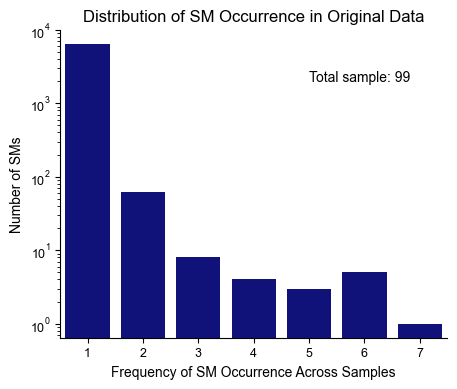

In [5]:
# 展示出现在一个样本的SM数量、出现在两个样本的SM数量、出现在三个样本的SM数量等
plt.figure(figsize=(5,4))
sns.barplot(x=dupSNP.index, y=dupSNP.values,color="darkblue")
plt.title("Distribution of SM Occurrence in Original Data", fontsize=12)
plt.xlabel("Frequency of SM Occurrence Across Samples", fontsize=10)
plt.ylabel("Number of SMs", fontsize=10)
plt.text(4, 2000, 'Total sample: 99', fontsize=10)
plt.yscale('log')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.savefig('SMinorin.pdf',dpi=300)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


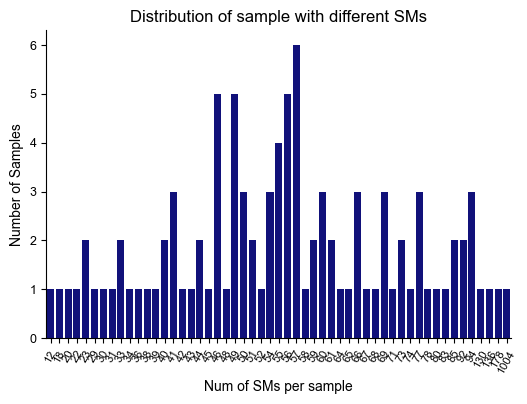

In [6]:
# 展示出现拥有一个SM的样本数量、拥有两个SM的样本数量、拥有三个SM的样本数量等

plt.figure(figsize=(6,4))
sns.barplot(x=dupSample.index, y=dupSample.values,color="darkblue")
plt.title("Distribution of sample with different SMs", fontsize=12)
plt.xlabel("Num of SMs per sample", fontsize=10)
plt.ylabel("Number of Samples", fontsize=10)
#plt.text(4, 2000, 'Total SMs: 9654', fontsize=10)
plt.xticks(fontsize=8,rotation=60)
plt.yticks(fontsize=9)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.savefig('nsample_diff_nSMs.pdf',dpi=300,bbox_inches='tight')

## Overlapped 的结果  
* Overlapped 的 SM 的数量与没有 overlapped 的 SM  

* 每个 Sample 中的 Overlapped SM 的比例

* SM 与 loop 的交集频率(与一个loop交集的SM有几个，与两个loop交集的SM有几个)

* overlapped SM 在样本中出现频次的分布（出现在一个样本的SM有几，出现两个样本的SMs有几个） 

* 样本中的 overlapped SM 数量的频次分布（含有一个SM的样本有几个，含有两个SM的样本有几个）   

In [5]:
# parirtobed 处理的数据
SM_loop=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/result/all/SM_loop_1k_fil.bedpe',sep='\t',header=None)
SM_loop.columns=['chr1','start1','end1','chr2','start2','end2','duplicated_loop','chr','start','end','index']


SM_loop_gene=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/result/all/SM_loop_1k_tss_gene.bedpe',sep='\t',header=None)
SM_loop_gene.drop(columns=[11, 12, 13, 15, 16], inplace=True)
SM_loop_gene.columns=['chr1','start1','end1','chr2','start2','end2','duplicated_loop','chr','start','end','index','ENSG','symbol','genetype']


# SM_loop_or=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/result/all/SM_loop.bedpe',sep='\t',header=None)
# SM_loop_or.columns=['chr1','start1','end1','chr2','start2','end2','duplicated_loop','chr','start','end','index']

In [6]:
# 有 loop gene 的数据
# 合并 int 转变为 float，因为数据中有 NA
SNP_loop_s=pd.merge(SM_loop_gene,SNP,on='index',how='outer')
SNP_loop_ss=SNP_loop_s.loc[:,['index','hg19id','Variant_Classification','Hugo_Symbol','Tumor_Sample_Barcode','dbSNP_RS','Variant_Type','chr1','start1','end1','chr2','start2','end2','chr','start','end','ENSG','symbol','genetype']]

SNP_loop_ss['loopid'] = np.where(
    SNP_loop_ss[['chr1', 'start1', 'end1', 'chr2', 'start2', 'end2']].isna().any(axis=1),
    np.nan,  # 如果有任何 NA，则设置为 NA
    SNP_loop_ss['chr1'] + '_' + 
    (((SNP_loop_ss['start1'] + SNP_loop_ss['end1']) / 2).fillna(0).astype(int).astype(str)) + '_' +  # 计算中点，转换为 int 再转换为 str
    SNP_loop_ss['chr2'] + '_' + 
    (((SNP_loop_ss['start2'] + SNP_loop_ss['end2']) / 2).fillna(0).astype(int).astype(str))  # 同样处理
)


In [ ]:
# genebed=pd.read_csv('/cluster/home/futing/ref_genome/hg38_gencode/genebed/gencode.v43.gene.bed',sep='\t',header=None)
# # genebed.drop(columns=[3,4,5,7,8],inplace=True)
# genebed.columns=['chr','start','end','ENSG','dot','strand','symbol','type','biggertype']
# genebed = genebed.drop_duplicates(subset=genebed.columns[6]).query('type == "protein_coding"')
#genebed.drop(columns=['ENSG','dot','strand','type','biggertype'],inplace=True)

In [7]:
genebed = pd.read_csv('/cluster/home/futing/ref_genome/hg38_gencode/genebed/gencode.v43.gene.bed', sep='\t', header=None)
genebed.columns = ['chr', 'start', 'end', 'ENSG', 'dot', 'strand', 'symbol', 'type', 'biggertype']

# 当第6列（symbol）出现重复时，只保留protein_coding的行
genebed = genebed.sort_values('type', key=lambda x: x != 'protein_coding').drop_duplicates(subset='symbol', keep='first')

genebed.drop(columns=['ENSG', 'dot', 'strand', 'type', 'biggertype'], inplace=True)

In [38]:
genebed.head()

,chr,start,end,symbol
31351,chr10,49982189,50011654,AGAP6
48662,chr17,8368637,8383187,ENSG00000263809
48663,chr17,8377515,8383213,RPL26
20677,chr6,56056589,56394094,COL21A1
20675,chr6,55753652,55875590,BMP5


#### 检测 Hugo Symbol 和 hg19id 的位置关系

In [11]:
# 看一下 SM 文件里的 Hugo_Symbol 列作用
SNP_loop_ssg=pd.merge(SNP_loop_ss,genebed,left_on='Hugo_Symbol',right_on='symbol',how='left')
SNP_loop_ssg.loc[:,'inGene']=np.where(
    SNP_loop_ssg[['chr_y', 'start_y', 'end_y', 'symbol_y']].isna().any(axis=1),
    np.nan,  # 如果有任何 NA，则设置为 NA  发现有些基因没有匹配的位置信息
    np.where(
        (SNP_loop_ssg['start_x']>=SNP_loop_ssg['start_y']) & (SNP_loop_ssg['end_x']<=SNP_loop_ssg['end_y']),
        1,
        0
    )
)

In [12]:
# 发现 x1 x2 不一样
x1=SNP_loop_ssg[['hg19id','Hugo_Symbol','inGene']].drop_duplicates()
x2=SNP_loop_ssg[['hg19id','Hugo_Symbol']].drop_duplicates()
x2=x2.reindex(x1.index,fill_value=0)
x2.compare(x1.iloc[:,[0,1]]) # 发现有些基因有两个位置信息，所以有两个 inGene 信息

Empty DataFrame
Columns: []
Index: []

In [13]:
SNP_loop_ssg.loc[SNP_loop_ssg['hg19id']=='chr15_28948484_28948484',]

,index,hg19id,Variant_Classification,Hugo_Symbol,Tumor_Sample_Barcode,dbSNP_RS,Variant_Type,chr1,start1,end1,...,end_x,ENSG,symbol_x,genetype,loopid,chr_y,start_y,end_y,symbol_y,inGene
19014,2928,chr15_28948484_28948484,Missense_Mutation,GOLGA8M,C3L-02970,rs377742692,SNP,chr15,22580000.0,22610000.0,...,28703338,ENSG00000291261.1,ENSG00000291261,lncRNA,chr15_22595000_chr15_28715000,chr15,28698582.0,28738384.0,GOLGA8M,1.0
19015,2928,chr15_28948484_28948484,Missense_Mutation,GOLGA8M,C3L-02970,rs377742692,SNP,chr15,22580000.0,22610000.0,...,28703338,ENSG00000277515.1,RN7SL495P,misc_RNA,chr15_22595000_chr15_28715000,chr15,28698582.0,28738384.0,GOLGA8M,1.0
19016,2928,chr15_28948484_28948484,Missense_Mutation,GOLGA8M,C3L-02970,rs377742692,SNP,chr15,22580000.0,22610000.0,...,28703338,ENSG00000274632.1,RN7SL719P,misc_RNA,chr15_22595000_chr15_28715000,chr15,28698582.0,28738384.0,GOLGA8M,1.0


In [16]:
# hg19和Hugo_Symbol的对应关系
SNP_loop_ssgs=SNP_loop_ssg.loc[:,['hg19id','inGene','Hugo_Symbol','chr_x','start_x','end_x','chr_y','start_y','end_y']].drop_duplicates()
print(f'Num of genes correspond to hg19id is {SNP_loop_ssgs['inGene'].value_counts().sum()}') #6534总共hg19id 6325个对应的Huget_Symbol是有注释
print(f'Non-match gene num is {SNP_loop_ssgs['inGene'].isna().sum()}') #209个没有匹配到基因的hg19id
print(f'Result of match gene is {SNP_loop_ssgs["inGene"].value_counts()}') # 有6325个hg19id对应的基因有注释，209个没有匹配到基因的hg19id

Num of genes correspond to hg19id is 6325
Non-match gene num is 209
Result of match gene is inGene
1.0    6321
0.0       4
Name: count, dtype: int64


In [ ]:
# 看看不在基因内的 hg19id 和 Hugo_Symbol 是什么关系
SNP_loop_ssgs[SNP_loop_ssgs.loc[:,'inGene']==0.0]

,hg19id,inGene,Hugo_Symbol,chr_x,start_x,end_x,chr_y,start_y,end_y
5692,chr15_85360142_85360142,0.0,ALPK3,chr15,84816910,84816911,chr15,84817355.0,84873479.0
14563,chr1_13648278_13648278,0.0,PRAMEF15,chr1,12825319,12825320,chr1,13315580.0,13322598.0
21472,chr18_11644585_11644585,0.0,SLC35G4,chr18,11644585,11644586,chr18,11609595.0,11610612.0
21541,chr1_145302655_145302656,0.0,NBPF26,chr1,146135518,146135520,chr1,120723948.0,120842110.0


In [17]:
# 看不在基因内的SM与Hugo_Symbol的关系
# 使用 pd.notnull() 确保参与计算的列没有NA值
mask = (SNP_loop_ssgs['inGene'] == 0) & pd.notnull(SNP_loop_ssgs['end_x']) & pd.notnull(SNP_loop_ssgs['start_y']) & pd.notnull(SNP_loop_ssgs['start_x']) & pd.notnull(SNP_loop_ssgs['end_y'])

SNP_loop_ssgs.loc[mask, 'distance'] = np.where(
    SNP_loop_ssgs.loc[mask, 'end_x'] < SNP_loop_ssgs.loc[mask, 'start_y'],
    SNP_loop_ssgs.loc[mask, 'start_y'] - SNP_loop_ssgs.loc[mask, 'end_x'],
    SNP_loop_ssgs.loc[mask, 'start_x'] - SNP_loop_ssgs.loc[mask, 'end_y']
)

In [18]:
SNP_loop_ssgs['distance'].describe().apply(lambda x: f'{x:.2f}')

count           4.00
mean      6454521.25
std      12561244.89
min           444.00
25%         25590.75
50%        262116.50
75%       6691047.00
max      25293408.00
Name: distance, dtype: object

### 正常处理 SNP loop

In [7]:
# 合并 overlap 和原始数据
SNP_loop=pd.merge(SNP,SM_loop,on='index',how='outer')
#SNP_loop_or=pd.merge(SNP,SM_loop_or,on='index',how='outer')
# 截取有用的信息
SNP_loop_simple=SNP_loop.loc[:,['index','hg19id','Variant_Classification','Hugo_Symbol','Tumor_Sample_Barcode','dbSNP_RS','Variant_Type','chr1','start1','end1','chr2','start2','end2','chr','start','end']]
SNP_loop['hg19id'].unique().shape # 一共 6534 个SNP

(6534,)

In [19]:
SNP_loop_simple.loc[:,'score']=[1 if pd.notna(i) else 0 for i in SNP_loop_simple['chr1']] #chr1指示是否为loop

非零值的个数: 3660


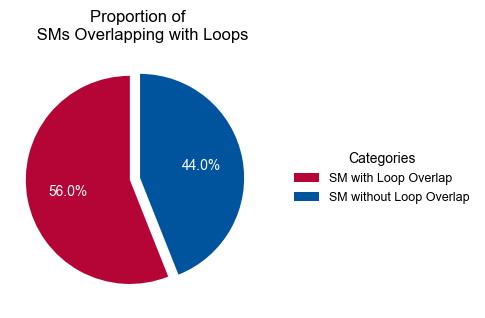

In [9]:
# Overlapped SM num VS Non-overlapped SM num

nonzero_count = (SNP_loop_simple.groupby('hg19id')['chr1'].count() > 0).sum() #6534
print("非零值的个数:", nonzero_count) #3723
zero_count = (SNP_loop_simple.groupby('hg19id')['chr1'].count() == 0).sum() # 6534-3660=2874

# 数据
labels = ['SM with Loop Overlap', 'SM without Loop Overlap']
sizes = [nonzero_count, zero_count]  # 各类别的数量
colors = ['#B40536','#00549E' ]  # 饼图的颜色
explode = (0.1, 0)  # 突出显示第一个类别

# 绘制饼图
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=None, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode,textprops={'color': 'white'})
plt.title('Proportion of \n SMs Overlapping with Loops', fontsize=12)
plt.legend(labels, loc='center left',bbox_to_anchor=(1.05, 0.5), fontsize=9, frameon=False, title="Categories", title_fontsize=10)
plt.tight_layout()
#plt.savefig('SM_loop_overlap.pSNP_loop_simple',dpi=300，bbox_inches='tight')

In [10]:
# SNP与loop交集的的频率 的分布（重叠1次的有多少个,重叠2次的有多少个，分开考虑不同样本的SNP）
#nloopedSM=pd.Series(SNP_loop_simple.loc[pd.notna(SNP_loop_simple['chr1']),'index'].value_counts().values).value_counts()
#nloopSM=SNP_loop_simple.groupby('index')['chr1'].count().value_counts()
nloopSM=SNP_loop_simple.groupby('hg19id')['chr1'].count().value_counts() #chr1 是 loop 的坐标，NA 表示没有loop
nloopSM_ss=SNP_loop_ss.groupby('hg19id')['loopid'].count().value_counts() #chr1 是 loop 的坐标，NA 表示没有loop

In [14]:
nloopSM.sum() # 6534

6534

In [ ]:
# 看一下很多loop的SNP是什么样的
SNP_loop_simple.groupby('hg19id')['chr1'].count().sort_values(ascending=False)

hg19id
chr8_128752761_128752761    37
chr1_89449135_89449135      28
chr7_14758253_14758253      28
chr12_64825380_64825380     28
chr2_172571954_172571954    27
                            ..
chr3_151046084_151046084     0
chr3_155232647_155232647     0
chr3_15778657_15778657       0
chr3_160560076_160560076     0
chr3_178928057_178928058     0
Name: chr1, Length: 6534, dtype: int64

In [ ]:
# 详细的信息
SNP_loop_simple.loc[SNP_loop_simple['hg19id']=='chr2_172571954_172571954',:]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


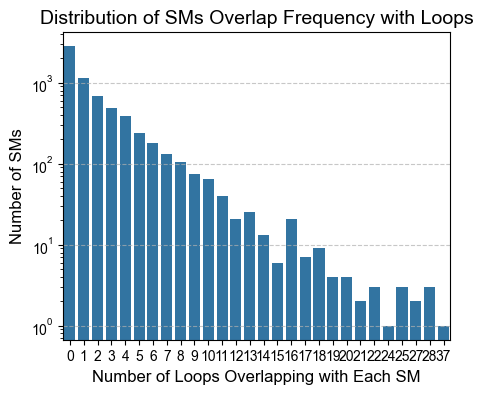

In [16]:

plt.figure(figsize=(5,4))
sns.barplot(x=nloopSM.index, y=nloopSM.values)
plt.title("Distribution of SMs Overlap Frequency with Loops", fontsize=14)
plt.xlabel("Number of Loops Overlapping with Each SM", fontsize=12)
plt.ylabel("Number of SMs", fontsize=12)
plt.yscale('log')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.savefig('nloop_perSM2.pdf',dpi=300,bbox_inches='tight')

In [20]:
# 统计每个 overlap SNP 在样本中出现的频率，然后统计这个频率的分布。即出现在一个样本的SNP有多少个，出现在两个样本的SNP有多少个

# loopscore=pd.crosstab(SNP_loop_simple_long['ID'], df_long['Variable'])
df_wide = SNP_loop_simple.pivot_table(index='Tumor_Sample_Barcode', columns='hg19id', values='score', aggfunc='sum') # 统计了每个样本中每个SNP出现的次数
df_wide.fillna(0, inplace=True)
snpsample=(df_wide>0).sum(axis=0).value_counts()#6534，大于0的个数（不是直接计算每列的和），再统计每列和的分布
snpsample1=SNP_loop_simple[SNP_loop_simple['score']!=0].groupby('hg19id')['Tumor_Sample_Barcode'].nunique().value_counts()#6534，只能先筛选出有loop的数据，然后再统计每列和的分布，这样会丢弃掉没有loop的样本
snpsample,snpsample1

(1    3619
 0    2874
 2      33
 3       4
 6       3
 7       1
 Name: count, dtype: int64,
 Tumor_Sample_Barcode
 1    3619
 2      33
 3       4
 6       3
 7       1
 Name: count, dtype: int64)

In [ ]:
snpsample1.sum(),snpsample.sum() # 3660, 6534,3723

(3660, 0)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


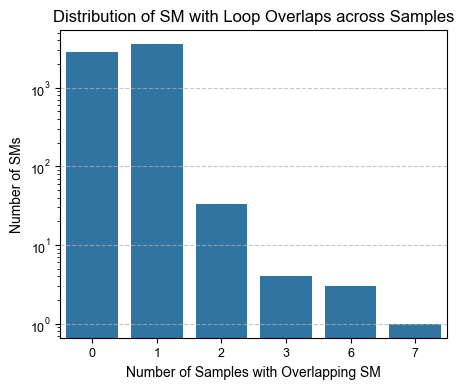

In [21]:
# 大部分的SNP只出现在一个样本中
plt.figure(figsize=(5,4))
sns.barplot(x=snpsample.index.astype(int), y=snpsample.values)
plt.title("Distribution of SM with Loop Overlaps across Samples", fontsize=12)
plt.xlabel("Number of Samples with Overlapping SM", fontsize=10)
plt.ylabel("Number of SMs", fontsize=10)
plt.yscale('log')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.savefig('noverlapSM_diff_nsample.pdf',dpi=300,bbox_inches='tight')

In [ ]:
# 统计拥有不同数量的SM的样本数量的分布，即多少样本有一个SM，多少样本有两个SM

samplesnp=(df_wide>0).sum(axis=1).value_counts().sort_index()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


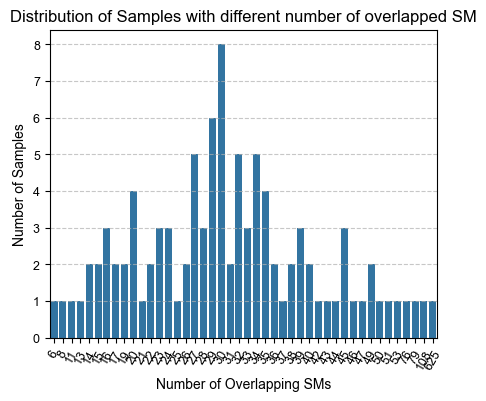

In [23]:
# 大部分样本都拥有overlapped SM

plt.figure(figsize=(5,4))
sns.barplot(x=samplesnp.index.astype(int), y=samplesnp.values)
plt.title("Distribution of Samples with different number of overlapped SM", fontsize=12)
plt.xlabel("Number of Overlapping SMs", fontsize=10)
plt.ylabel("Number of Samples", fontsize=10)

plt.xticks(fontsize=9,rotation=60)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.savefig('nsample_diff_noverlapSM.pdf',dpi=300,bbox_inches='tight')

In [24]:
# 每个样本 overlaped SM 和 non-overlaped SM 的数量比例

# dupSample=SNP['Tumor_Sample_Barcode'].value_counts() # 有几个样本有重复的SM 这种方法不对
# SNP.loc[SNP['Tumor_Sample_Barcode']=='C3L-01887','hg19id'].duplicated().sum() #1

# 正确数量的方法，去掉每个样本中duplicated的SM
dupSample=SNP.groupby('Tumor_Sample_Barcode')['hg19id'].nunique() 
all_persample=SNP_loop_simple.groupby('Tumor_Sample_Barcode')['hg19id'].nunique()
# all_persample_aligned=all_persample.reindex(dupSample.index,fill_value=0) # 比较两种方法的结果
# all_persample_aligned.compare(dupSample,align_axis=0)

# 统计有score的SM的样本中，每个样本中有多少个SM
overlap_persample=SNP_loop_simple[SNP_loop_simple['score']>0].groupby('Tumor_Sample_Barcode')['hg19id'].nunique().reindex(all_persample.index,fill_value=0)

overlap_ratio=overlap_persample/all_persample
overlap_ratio=overlap_ratio.sort_values(ascending=False)

/tmp/ipykernel_50491/2998767917.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=overlap_ratio.index, y=overlap_ratio.values,palette=colors,edgecolor='black',linewidth=0.2)


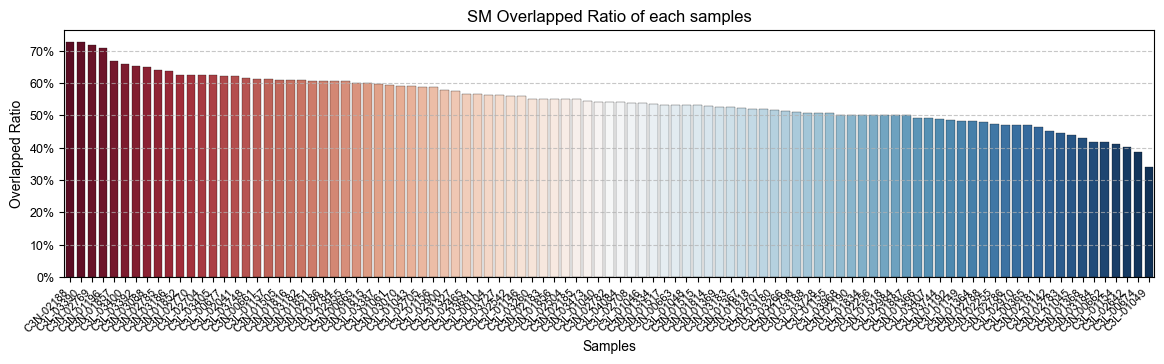

In [ ]:
# 统计每个样本大概有多少处于loop中的SM
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#16365F","#77A3BB","#F8F2ED","#D64F38"])
# colors = [custom_cmap(i / (len(overlap_ratio) - 1)) for i in range(len(overlap_ratio))]
colors = [plt.cm.RdBu(i / (len(overlap_ratio) - 1)) for i in range(len(overlap_ratio))]


plt.figure(figsize=(12,4))
sns.barplot(x=overlap_ratio.index, y=overlap_ratio.values,palette=colors,edgecolor='black',linewidth=0.2)



plt.title("SM Overlapped Ratio of each samples", fontsize=12)
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Overlapped Ratio", fontsize=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.xticks(ticks=range(len(overlap_ratio)), labels=overlap_ratio.index, fontsize=8, rotation=45, ha='right')
plt.yticks(fontsize=9)

# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
plt.tight_layout(pad=2.0)  
#plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.savefig('ploop_persample.pdf',dpi=300,bbox_inches='tight')


## SM load per gene

In [9]:
RNAexp=pd.read_csv('/cluster/home/futing/Project/GBM/RNA/merge/merged_RNA.txt',sep="\t")
summary=pd.read_csv("/cluster/home/futing/Project/GBM/RNA/merge/summary.txt",sep="\t",index_col=0)
id=summary.loc[summary['kmeans'].notna(),'id']

In [10]:
SNP_loop_ss.head()

,index,hg19id,Variant_Classification,Hugo_Symbol,Tumor_Sample_Barcode,dbSNP_RS,Variant_Type,chr1,start1,end1,chr2,start2,end2,chr,start,end,ENSG,symbol,genetype,loopid
0,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33480000.0,33510000.0,chr1,34750000.0,34780000.0,chr1,34761547,34761548,ENSG00000189280,GJB5,protein_coding,chr1_33495000_chr1_34765000
1,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33480000.0,33510000.0,chr1,34750000.0,34780000.0,chr1,34761547,34761548,ENSG00000189433,GJB4,protein_coding,chr1_33495000_chr1_34765000
2,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33610000.0,33640000.0,chr1,34740000.0,34770000.0,chr1,34761547,34761548,ENSG00000189280,GJB5,protein_coding,chr1_33625000_chr1_34755000
3,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33610000.0,33640000.0,chr1,34740000.0,34770000.0,chr1,34761547,34761548,ENSG00000189433,GJB4,protein_coding,chr1_33625000_chr1_34755000
4,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33620000.0,33650000.0,chr1,34760000.0,34790000.0,chr1,34761547,34761548,ENSG00000188910,GJB3,protein_coding,chr1_33635000_chr1_34775000


### 包含所有的

In [ ]:
SMload=SNP_loop_ss.groupby('symbol')['hg19id'].count().sort_values(ascending=False) # 每个symbol有多少的hg19id
# SNP_loop_ss.groupby('Hugo_Symbol')['hg19id'].count().sort_values(ascending=False) #每个原始的hugo_symbol有多少的hg19id
SMload.head()

symbol
Y_RNA              365
ENSG00000289752    101
PCDHB16             79
ENSG00000279068     79
PCDHB9              79
Name: hg19id, dtype: int64

In [115]:
# 合并 RNA exp 和 SMload 为 corRNA
RNAexp_fil=RNAexp.loc[RNAexp.index.isin(id),:]
RNAexp_filmean=RNAexp_fil.mean(axis=0)
RNAexp_filmean.name = "RNAexp"
SMload.name = "SMload"
corRNA=pd.merge(RNAexp_filmean,SMload,left_index=True,right_index=True,how='inner')

In [ ]:
corRNA=pd.merge(RNAexp_fil.T,SMload,left_index=True,right_index=True,how='inner')
corlist=corRNA.iloc[:,:-1].apply(lambda x: x.corr(corRNA['SMload']),axis=0)

In [77]:
corlist.sort_values(ascending=False)

G412R               0.021837
G412                0.015894
G402                0.014420
G148                0.013513
G402R               0.013208
G171                0.011078
G390                0.010478
G452C               0.010166
G275                0.010023
G452P               0.009742
G275R               0.009433
U343                0.009115
G318                0.008583
G23                 0.008119
G450                0.007472
P529.SF12794v6-1    0.007425
G181                0.007089
G120                0.006909
P529.SF12794v8-1    0.006788
42MGBA              0.006449
G457                0.006203
G62                 0.006175
G208                0.006112
G213                0.006099
G351                0.006073
U251                0.005839
H4                  0.005559
A172                0.005448
G163                0.005166
SW1088              0.005038
G394                0.005028
G323                0.004805
G1                  0.004775
U87                 0.004370
G83           

In [82]:
from scipy.stats import zscore
corRNA['zscoreRNA']=zscore(np.log10(corRNA['RNAexp']+1))
corRNA['SMloadlog']=np.log10(corRNA['SMload']+1)

In [83]:
print(corRNA['RNAexp'].corr(corRNA['SMload']))
print(corRNA['zscoreRNA'].corr(corRNA['SMload']))
print(corRNA['zscoreRNA'].corr(corRNA['SMloadlog']))

0.035621919624284584
0.0425055014868763
0.05761549288454971


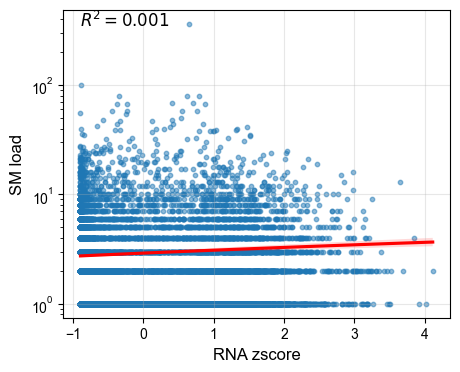

In [ ]:
from scipy.stats import linregress
# 回归线
x = corRNA['zscoreRNA']
y = corRNA['SMloadlog']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value**2  # 计算 R^2 值

# 绘制散点图和回归线
plt.figure(figsize=(5, 4))
sns.regplot(x=x, y=y, scatter_kws={'s': 10, 'alpha': 0.5}, line_kws={'color': 'red'})

# 添加 R^2 值到图中
plt.text(
    x.min(), y.max() * 0.95,  # 文本位置
    f'$R^2 = {r_squared:.3f}$',  # 格式化 R^2
    fontsize=12, color='black'
)

# 设置标题和标签
#plt.title('Scatter plot with regression line', fontsize=15)
plt.xlabel('RNA zscore', fontsize=12)
plt.ylabel('SM load', fontsize=12)
plt.yscale('log')
plt.grid(alpha=0.3)

In [ ]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x=RNA_zscore, y=log_SM_load, alpha=0.3, s=15)

# 添加非线性拟合曲线（LOESS 示例）
sns.regplot(x=RNA_zscore, y=log_SM_load, scatter=False, color='red', lowess=True)

# 计算线性回归
slope, intercept, r_value, _, _ = linregress(RNA_zscore, log_SM_load)
plt.plot(RNA_zscore, slope * RNA_zscore + intercept, color='blue', label=f'Linear R²={r_value**2:.3f}')


### 仅考虑loop的

In [12]:
SM_looponly=pd.merge(SNP_loop_ss,genebed,on='symbol',how='left')

In [13]:
SM_looponly.loc[:,'inGene']=np.where(
    SM_looponly[['chr_y', 'start_y', 'end_y']].isna().any(axis=1),
    np.nan,  # 如果有任何 NA，则设置为 NA  发现有些基因没有匹配的位置信息
    np.where(
        (SM_looponly['start_x']>=SM_looponly['start_y']) & (SM_looponly['end_x']<=SM_looponly['end_y']),
        1,
        0
    )
)

In [ ]:
print(SM_looponly['inGene'].value_counts())
print(SM_looponly['inGene'].isna().sum()) #2408 和前面的没有gene交集的loop的数量一样
print(SM_looponly['inGene'].shape) #42780

inGene
0.0    30000
1.0    10372
Name: count, dtype: int64
2408
(42780,)


In [ ]:
# 挑选loop交集的数据
SM_looponlyfil=SM_looponly.loc[SM_looponly['inGene']==0,:]
SMloadonly=SM_looponlyfil.groupby('symbol')['hg19id'].count().sort_values(ascending=False)

In [120]:
# 合并 RNA exp 和 SMload 为 corRNA
RNAexp_fil=RNAexp.loc[RNAexp.index.isin(id),:]
RNAexp_filmean=RNAexp_fil.mean(axis=0)
RNAexp_filmean.name = "RNAexp"
SMloadonly.name = "SMload"
corRNAonly=pd.merge(RNAexp_filmean,SMloadonly,left_index=True,right_index=True,how='inner')

In [121]:
corRNAex=pd.merge(RNAexp_fil.T,SMloadonly,left_index=True,right_index=True,how='inner')
corRNAex.iloc[:,:-1]=corRNAex.iloc[:,:-1].apply(lambda x: zscore(np.log10(x+1)))
corRNAex.iloc[:,:-1].apply(lambda x: x.corr(corRNAex['SMload']),axis=0).sort_values(ascending=False)

U343                0.022902
SW1088              0.017032
P498.SF12251        0.016845
P529.SF12794v6-1    0.015749
G412R               0.011813
U87                 0.011736
P475.SF12180        0.010084
G402R               0.009411
P519.SF12601        0.009255
U118                0.008983
G412                0.008961
G318                0.008049
G390                0.007388
G171                0.007318
G213                0.007275
G402                0.005461
G120                0.005052
G323                0.005010
A172                0.004994
G275R               0.004701
42MGBA              0.003912
G452P               0.003356
G61                 0.003150
P503.SF12518        0.002992
P455.SF11901        0.002852
G452C               0.002772
G450                0.002706
U251                0.002636
G181                0.002352
P529.SF12794v8-1    0.002239
G275                0.000612
P530.SF12822v4     -0.000191
G394               -0.000226
P521.SF12631       -0.001093
P530.SF12822v5

In [122]:
from scipy.stats import zscore
corRNAonly['zscoreRNA']=zscore(np.log10(corRNAonly['RNAexp']+1))

In [60]:
print(corRNAonly['RNAexp'].corr(corRNAonly['SMload']))
print(corRNAonly['zscoreRNA'].corr(corRNAonly['SMload']))

-0.0029028895108452325
0.01380930875701126


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 34 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'F', 'M', 'N', 'R', 'S', 'a', 'c', 'd', 'e', 'five', 'four', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'q', 'r', 's', 'space', 't', 'three', 'two', 'u', 'y', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 19, 20, 21, 22, 23, 24, 36, 38, 41, 48, 49, 53, 54, 68, 70, 71, 72, 79, 81, 82, 84, 85, 86, 87, 88, 92, 93, 237]
INFO:fontTools.subset:Closed glyph list over

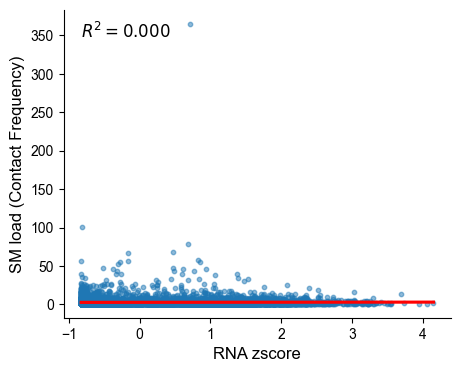

In [ ]:
from scipy.stats import linregress
# 回归线
x = corRNAonly['zscoreRNA']
y = corRNAonly['SMload']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value**2  # 计算 R^2 值

# 绘制散点图和回归线
plt.figure(figsize=(5, 4))
sns.regplot(x=x, y=y, scatter_kws={'s': 10, 'alpha': 0.5}, line_kws={'color': 'red'})

# 添加 R^2 值到图中
plt.text(
    x.min(), y.max() * 0.95,  # 文本位置
    f'$R^2 = {r_squared:.3f}$',  # 格式化 R^2
    fontsize=12, color='black'
)

# 设置标题和标签
#plt.title('Scatter plot with regression line', fontsize=15)
plt.xlabel('RNA zscore', fontsize=12)
plt.ylabel('SM load (Contact Frequency)', fontsize=12)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.yscale('log')
# plt.grid(alpha=0.3)
# plt.savefig('RNA_SMload_freq.pdf',dpi=300,bbox_inches='tight')

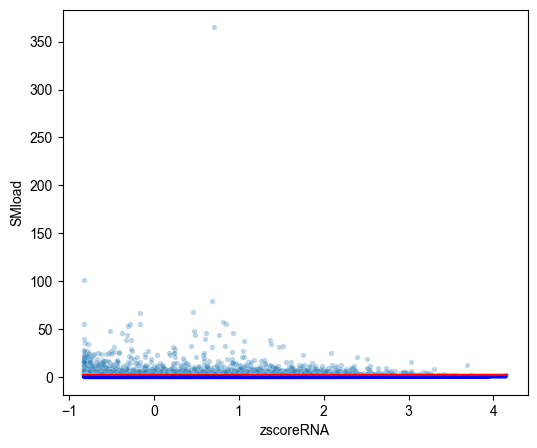

In [95]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x=x, y=y, alpha=0.3, s=15)

# 添加非线性拟合曲线（LOESS 示例）
sns.regplot(x=x, y=y, scatter=False, color='red', lowess=True)

# 计算线性回归
slope, intercept, r_value, _, _ = linregress(y, x)
plt.plot(x, slope *y + intercept, color='blue', label=f'Linear R²={r_value**2:.3f}')


### 获取 SM 附近的Hi-C contact，添加为score  

* 用raw contact 完全不行


In [ ]:

SM_lofilshort=SM_looponlyfil.loc[:,['index','hg19id','loopid','Tumor_Sample_Barcode','ENSG','symbol','genetype','chr1','start1','end1','chr2','start2','end2','chr_x','start_x','end_x']]
SM_lofilshort=SM_lofilshort.fillna(np.nan)
SM_lofilshort[SM_lofilshort.select_dtypes(include=['float64']).columns] = SM_lofilshort.select_dtypes(include=['float64']).astype('Int64')
SM_lofilshort.apply(lambda x: type(x[0]))

In [136]:

SNP_loop_ss=SNP_loop_ss.loc[:,['index','hg19id','loopid','Tumor_Sample_Barcode','ENSG','symbol','genetype','chr1','start1','end1','chr2','start2','end2','chr','start','end']]
SNP_loop_ss=SNP_loop_ss.fillna(np.nan)
SNP_loop_ss[SNP_loop_ss.select_dtypes(include=['float64']).columns] = SNP_loop_ss.select_dtypes(include=['float64']).astype('Int64')
SNP_loop_ss.apply(lambda x: type(x[0]))

index                   <class 'numpy.int64'>
hg19id                          <class 'str'>
loopid                          <class 'str'>
Tumor_Sample_Barcode            <class 'str'>
ENSG                            <class 'str'>
symbol                          <class 'str'>
genetype                        <class 'str'>
chr1                            <class 'str'>
start1                  <class 'numpy.int64'>
end1                    <class 'numpy.int64'>
chr2                            <class 'str'>
start2                  <class 'numpy.int64'>
end2                    <class 'numpy.int64'>
chr                             <class 'str'>
start                   <class 'numpy.int64'>
end                     <class 'numpy.int64'>
dtype: object

In [100]:
SM_lofilshort.head()

,index,hg19id,loopid,Tumor_Sample_Barcode,ENSG,symbol,genetype,chr1,start1,end1,chr2,start2,end2,chr_x,start_x,end_x
0,2,chr1_35227149_35227149,chr1_33495000_chr1_34765000,C3L-00104,ENSG00000189280.3,GJB5,protein_coding,chr1,33480000.0,33510000.0,chr1,34750000.0,34780000.0,chr1,34761547,34761548
2,2,chr1_35227149_35227149,chr1_33625000_chr1_34755000,C3L-00104,ENSG00000189280.3,GJB5,protein_coding,chr1,33610000.0,33640000.0,chr1,34740000.0,34770000.0,chr1,34761547,34761548
4,2,chr1_35227149_35227149,chr1_33635000_chr1_34775000,C3L-00104,ENSG00000188910.8,GJB3,protein_coding,chr1,33620000.0,33650000.0,chr1,34760000.0,34790000.0,chr1,34761547,34761548
7,4,chr1_91841089_91841089,chr1_91385000_chr1_156215000,C3L-00104,ENSG00000260238.6,PMF1-BGLAP,protein_coding,chr1,91370000.0,91400000.0,chr1,156200000.0,156230000.0,chr1,91375531,91375532
8,4,chr1_91841089_91841089,chr1_91385000_chr1_156215000,C3L-00104,ENSG00000160783.19,PMF1,protein_coding,chr1,91370000.0,91400000.0,chr1,156200000.0,156230000.0,chr1,91375531,91375532


In [16]:
GBM=cooler.Cooler("/cluster/home/futing/Project/GBM/HiC/02data/03cool/10000/GBM_10000.cool")
A172=cooler.Cooler("/cluster/home/futing/Project/GBM/HiC/02data/03cool/10000/A172_10000.cool")


In [ ]:
# GBM_pixels=GBM.pixels(join=True)[:].iloc[:100,:]
# GBM.matrix(balance=True)[:]
# 读不了

In [18]:
A172_bins=A172.bins()[:]
A172_pixels=A172.pixels(join=True)[:]
A172_bins.shape,A172_pixels.shape

((308837, 4), (49031319, 7))

In [26]:
def get_binid(chr1,start1,end1,chr2,start2,end2,bins=A172_bins):
    startmid1=(start1+end1)//2
    startmid2=(start2+end2)//2
    bin1=bins[(bins['chrom']==chr1) & (bins['start']<=startmid1) & (bins['end']>=startmid1)]
    bin2=bins[(bins['chrom']==chr2) & (bins['start']<=startmid2) & (bins['end']>=startmid2)]
    if bin1.empty or bin2.empty:
        return None, None  # 如果找不到匹配的bin，返回None
    return bin1.index[0],bin2.index[0]

In [ ]:
A172_bins.head()
bins=A172_bins
chr1='chr1'
start1=33480000	
end1=33510000
chr2='chr1'
start2=34750000
end2=34780000
get_binid(chr1,start1,end1,chr2,start2,end2)

In [ ]:
# 为每个loop找到对应的bin
SM_lofilshort.loc[SM_lofilshort['loopid'].notna(),'bin1'], SM_lofilshort.loc[SM_lofilshort['loopid'].notna(),'bin2'] = zip(*SM_lofilshort.loc[SM_lofilshort['loopid'].notna(),:].apply(
    lambda x: get_binid(x['chr1'], x['start1'], x['end1'], x['chr2'], x['start2'], x['end2']), axis=1))


In [19]:
# SM_lofilshort.to_csv('SM_lofilshort.txt',index=False,sep='\t')
SM_lofilshort=pd.read_csv('SM_lofilshort.txt',sep='\t')

In [27]:
SM_lofilshort[SM_lofilshort.select_dtypes(include=['float64']).columns] = SM_lofilshort.select_dtypes(include=['float64']).astype('Int64')
SM_lofilshort.apply(lambda x: type(x[0]))

index                   <class 'numpy.int64'>
hg19id                          <class 'str'>
loopid                          <class 'str'>
Tumor_Sample_Barcode            <class 'str'>
ENSG                            <class 'str'>
symbol                          <class 'str'>
genetype                        <class 'str'>
chr1                            <class 'str'>
start1                  <class 'numpy.int64'>
end1                    <class 'numpy.int64'>
chr2                            <class 'str'>
start2                  <class 'numpy.int64'>
end2                    <class 'numpy.int64'>
chr_x                           <class 'str'>
start_x                 <class 'numpy.int64'>
end_x                   <class 'numpy.int64'>
bin1                    <class 'numpy.int64'>
bin2                    <class 'numpy.int64'>
dtype: object

In [ ]:
# 看看pixels和matrix的关系
A172_pixels.loc[(A172_pixels['chrom1']=='chr1') & (A172_pixels['start1'] ==33490000) & (A172_pixels['start2'] == 34760000),:].head()

,chrom1,start1,end1,chrom2,start2,end2,count
383466,chr1,33490000,33500000,chr1,34760000,34770000,1


In [125]:
A172.matrix(balance=True).fetch('chr1:33490000-33500000','chr1:34760000-34770000')

array([[0.00318418]])

In [33]:
SM_lofilshort.head()

,index,hg19id,loopid,Tumor_Sample_Barcode,ENSG,symbol,genetype,chr1,start1,end1,chr2,start2,end2,chr_x,start_x,end_x,bin1,bin2,contact
0,2,chr1_35227149_35227149,chr1_33495000_chr1_34765000,C3L-00104,ENSG00000189280.3,GJB5,protein_coding,chr1,33480000,33510000,chr1,34750000,34780000,chr1,34761547,34761548,3349,3476,NaN
1,2,chr1_35227149_35227149,chr1_33625000_chr1_34755000,C3L-00104,ENSG00000189280.3,GJB5,protein_coding,chr1,33610000,33640000,chr1,34740000,34770000,chr1,34761547,34761548,3362,3475,NaN
2,2,chr1_35227149_35227149,chr1_33635000_chr1_34775000,C3L-00104,ENSG00000188910.8,GJB3,protein_coding,chr1,33620000,33650000,chr1,34760000,34790000,chr1,34761547,34761548,3363,3477,NaN
3,4,chr1_91841089_91841089,chr1_91385000_chr1_156215000,C3L-00104,ENSG00000260238.6,PMF1-BGLAP,protein_coding,chr1,91370000,91400000,chr1,156200000,156230000,chr1,91375531,91375532,9138,15621,NaN
4,4,chr1_91841089_91841089,chr1_91385000_chr1_156215000,C3L-00104,ENSG00000160783.19,PMF1,protein_coding,chr1,91370000,91400000,chr1,156200000,156230000,chr1,91375531,91375532,9138,15621,NaN


In [45]:
#308837
from joblib import Parallel, delayed

def fetch_contacts(row):
    matrix = GBM.matrix(balance=False).fetch(
        f'{row["chr1"]}:{row["start1"]+10000}-{row["end1"]-10000}',
        f'{row["chr2"]}:{row["start2"]+10000}-{row["end2"]-10000}'
    )
    if matrix.size == 1:
        return matrix.item()  # 返回标量值
    elif matrix.size == 0:
        return None  # 空数组返回 None
    else:
        print(f'Warning: {row["loopid"]} has more than one value')
        return matrix.mean()  


notna_indices = SM_lofilshort['loopid'].notna()
SM_lofilshort.loc[notna_indices, 'rawcontact'] = Parallel(n_jobs=-1)(
    delayed(fetch_contacts)(row) for _, row in SM_lofilshort.loc[notna_indices].iterrows()
)

# SM_lofilshort.loc[SM_lofilshort['loopid'].notna(), 'contact'] = SM_lofilshort.loc[
#     SM_lofilshort['loopid'].notna()
# ].apply(
#     lambda x: A172.matrix(balance=True).fetch(
#         f'{x["chr1"]}:{x["start1"]}-{x["end1"]}',
#         f'{x["chr2"]}:{x["start2"]}-{x["end2"]}'
#     ), axis=1
# )

# def get_contact(chr1,start1,end1,chr2,start2,end2,GBM=A172):

#     return A172.matrix(balance=True).fetch(f'{chr1}:{start1}-{end1}',f'{chr2}:{start2}-{end2}')
SM_lofilshort.to_csv('SM_lofilshort.txt',index=False,sep='\t')

In [157]:
SNP_loop_ss.head()

,index,hg19id,loopid,Tumor_Sample_Barcode,ENSG,symbol,genetype,chr1,start1,end1,chr2,start2,end2,chr,start,end,rawcontact
0,2,chr1_35227149_35227149,chr1_33495000_chr1_34765000,C3L-00104,ENSG00000189280,GJB5,protein_coding,chr1,33480000,33510000,chr1,34750000,34780000,chr1,34761547,34761548,164.0
1,2,chr1_35227149_35227149,chr1_33495000_chr1_34765000,C3L-00104,ENSG00000189433,GJB4,protein_coding,chr1,33480000,33510000,chr1,34750000,34780000,chr1,34761547,34761548,164.0
2,2,chr1_35227149_35227149,chr1_33625000_chr1_34755000,C3L-00104,ENSG00000189280,GJB5,protein_coding,chr1,33610000,33640000,chr1,34740000,34770000,chr1,34761547,34761548,235.0
3,2,chr1_35227149_35227149,chr1_33625000_chr1_34755000,C3L-00104,ENSG00000189433,GJB4,protein_coding,chr1,33610000,33640000,chr1,34740000,34770000,chr1,34761547,34761548,235.0
4,2,chr1_35227149_35227149,chr1_33635000_chr1_34775000,C3L-00104,ENSG00000188910,GJB3,protein_coding,chr1,33620000,33650000,chr1,34760000,34790000,chr1,34761547,34761548,192.0


In [164]:
# 那么对于原位的 hg19id 呢？
SNP_loop_ss.loc[:,'inGene']=SM_looponly.loc[:,'inGene']

In [148]:
notna_indices = SNP_loop_ss['loopid'].notna()
SNP_loop_ss.loc[notna_indices, 'rawcontact'] = Parallel(n_jobs=-1)(
    delayed(fetch_contacts)(row) for _, row in SNP_loop_ss.loc[notna_indices].iterrows()
)


In [166]:
# 对于原位的contact
ConInGene=SNP_loop_ss.loc[SNP_loop_ss['inGene']==1,:].groupby('symbol')['rawcontact'].sum().sort_values(ascending=False)
ConInGene=pd.merge(ConInGene,RNAexp_filmean,left_index=True,right_index=True,how='inner')

In [167]:
ConInGene=ConInGene.apply(lambda x: zscore(np.log10(x+1)))

In [168]:
print(ConInGene['rawcontact'].corr(ConInGene['RNAexp']))

0.20014918899530026


In [ ]:
# 对于所有的 hg19id 的 contact
# Con=SNP_loop_ss.groupby('symbol')['contact'].sum().sort_values(ascending=False)
Conrawall=SNP_loop_ss.groupby('symbol')['rawcontact'].sum().sort_values(ascending=False)
ConRNAall=pd.merge(Conrawall,RNAexp_filmean,left_index=True,right_index=True,how='inner')
ConRNAall=ConRNAall.apply(lambda x: zscore(np.log10(x+1)),axis=0)
print(ConRNAall['rawcontact'].corr(ConRNAall['RNAexp']))

In [ ]:
# 对于在loop上的 hg19id 的 contact
Con=SM_lofilshort.groupby('symbol')['contact'].sum().sort_values(ascending=False)
Conraw=SM_lofilshort.groupby('symbol')['rawcontact'].sum().sort_values(ascending=False)
# SNP_loop_ss.groupby('symbol')['hg19id'].count().sort_values(ascending=False)

In [138]:
ConRNA=pd.merge(RNAexp_filmean,Con,left_index=True,right_index=True,how='inner')
ConRNA=pd.merge(ConRNA,Conraw,left_index=True,right_index=True,how='inner')

In [140]:
ConRNA['zscoreRNA']=zscore(np.log10(ConRNA['RNAexp']+1))
ConRNA['zscorecont']=zscore(np.log10(ConRNA['contact']+1))
ConRNA['zscoreconraw']=zscore(np.log10(ConRNA['rawcontact']+1))

In [ ]:
print(ConRNA['zscoreRNA'].corr(ConRNA['zscorecont']))
print(ConRNA['zscoreRNA'].corr(ConRNA['contact']))
print(ConRNA['zscoreRNA'].corr(ConRNA['rawcontact']))
print(ConRNA['zscoreRNA'].corr(ConRNA['zscoreconraw']))

0.04840362927626777
0.04306598254466048
0.04406803004480682
0.08313265525265312


In [129]:
ConRNA['zscoreRNA'].max(),ConRNA['contact'].max()

(4.152132116747477, 1.868692229146102)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 40 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'H', 'I', 'L', 'M', 'N', 'R', 'S', 'a', 'c', 'd', 'e', 'five', 'four', 'hyphen', 'i', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'y', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 26, 36, 38, 40, 43, 44, 47, 48, 49, 53, 54, 68, 70, 71, 72, 76, 79, 81, 82, 83, 8

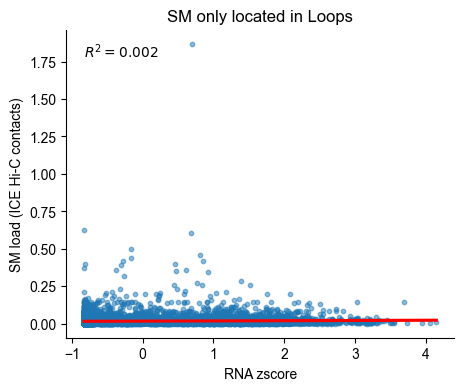

In [178]:
from scipy.stats import linregress

# all ConRNAall['RNAexp'] ConRNAall['rawcontact']
# inGene ConInGene['RNAexp'] ConInGene['rawcontact']
# inLoop ConRNA['zscoreRNA'] conRNA['zscoreconraw']
x = ConRNA['zscoreRNA']
y = ConRNA['contact']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value**2  # 计算 R^2 值

# 绘制散点图和回归线
plt.figure(figsize=(5, 4))
sns.regplot(x=x, y=y, scatter_kws={'s': 10, 'alpha': 0.5}, line_kws={'color': 'red'})

# 添加 R^2 值到图中
plt.text(
    x.min(), y.max() * 0.95,  # 文本位置
    f'$R^2 = {r_squared:.3f}$',  # 格式化 R^2
    fontsize=10, color='black'
)

# 设置标题和标签
plt.title('SM only located in Loops', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('RNA zscore', fontsize=10)
plt.ylabel('SM load (ICE Hi-C contacts)', fontsize=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.yscale('log')
# plt.grid(alpha=0.3)
plt.savefig('RNA_SMload_inloop_ICEhic.pdf',dpi=300,bbox_inches='tight')

## gene load per SM

In [ ]:
SNP_loop_ss.loc[:,'ENSG']=SNP_loop_ss['ENSG'].str.split('.').str[0]

In [ ]:
symbol_matrix = SNP_loop_ss.pivot_table(
    index='Tumor_Sample_Barcode',
    columns='hg19id',
    values='symbol',
    aggfunc=lambda x: ' '.join(x.dropna().astype(str).unique())
)
symbol_matrix.head()

hg19id,chr10_100017842_100017842,chr10_100183413_100183413,chr10_100481428_100481428,chr10_100481448_100481448,chr10_101295226_101295226,chr10_101646280_101646280,chr10_101689847_101689847,chr10_101716420_101716420,chr10_102822720_102822720,chr10_102896495_102896495,...,chrX_99854068_99854068,chrX_99854625_99854625,chrY_23710716_23710716,chrY_23710825_23710825,chrY_3447670_3447670,chrY_3447809_3447809,chrY_4925071_4925071,chrY_4925496_4925496,chrY_5605441_5605441,chrY_9304672_9304672
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
C3L-00104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00365,NaN,NaN,NaN,NaN,NaN,NaN,DNMBP-AS1 DNMBP,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00677,NaN,ENSG00000230928 LOXL4 PYROXD2 MIR4685,NaN,NaN,NaN,NaN,NaN,DNMBP-AS1 DNMBP,ENSG00000236662 TWNK MRPL43 LZTS2 ENSG00000273...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-01040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,TNMD,NaN,NaN,NaN,NaN,NaN,PCDH11Y,NaN,NaN,NaN


In [ ]:
SMgene=SNP_loop_ss.loc[:,['hg19id','Tumor_Sample_Barcode','ENSG','symbol','genetype']]
#SNP_loop_simple['genetype']=='protein_coding'
SMgene.drop_duplicates(inplace=True)
SMgene.dropna(subset=['ENSG'],inplace=True)
SMgene.shape #10464 25268(21292 dropna)

(24806, 5)

In [ ]:
SMgene.to_csv('SM_gene.csv',index=False,sep='\t')

In [ ]:
SMgene.head()

,hg19id,Tumor_Sample_Barcode,ENSG,symbol,genetype
0,chr1_35227149_35227149,C3L-00104,ENSG00000189280,GJB5,protein_coding
1,chr1_35227149_35227149,C3L-00104,ENSG00000189433,GJB4,protein_coding
4,chr1_35227149_35227149,C3L-00104,ENSG00000188910,GJB3,protein_coding
5,chr1_35227149_35227149,C3L-00104,ENSG00000255811,ENSG00000255811,lncRNA
6,chr1_47276490_47276490,C3L-00104,ENSG00000142973,CYP4B1,protein_coding


## SM occurence and survival

In [81]:
meta=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/mutation/gbm_cptac_2021_meta.bed',sep='\t')
print(meta.columns)
print(meta['PATIENT_ID'].isin(SNP['Tumor_Sample_Barcode'].unique()).sum())

Index(['PATIENT_ID', 'AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'BMI',
       'COUNTRY_OF_ORIGIN', 'RACE', 'ETHNICITY', 'ETHNICITY_SELF_IDENTIFY',
       'SMOKING_HISTORY', 'SECONDHAND_SMOKE_EXPOSURE', 'FOLLOW_UP_PERIOD',
       'VITAL_STATUS', 'PATH_DIAG_TO_LAST_CONTACT_DAYS',
       'PATH_DIAG_TO_DEATH_DAYS', 'CAUSE_OF_DEATH', 'LOST_TO_FOLLOW_UP',
       'TUMOR_REOCCUR_AFTER_TREATMENT', 'PATH_DIAG_TO_TUMOR_REOCCUR_DAYS',
       'EXPERT_PATH_REVIEW', 'EXPERT_PATH_REVIEW_NUM_SEGMENTS',
       'EXPERT_PATH_REVIEW_DETAILS', 'EXCLUDED_IN_DOWNSTREAM_ANALYSIS'],
      dtype='object')
99


### Overlapped loop的数据

In [82]:
#loopscore=pd.crosstab(df_long['ID'], df_long['Variable'])
df_wide = SNP_loop_simple.pivot_table(index='Tumor_Sample_Barcode', columns='hg19id', values='score', aggfunc='sum')
df_wide.head()

hg19id,chr10_100017842_100017842,chr10_100183413_100183413,chr10_100481428_100481428,chr10_100481448_100481448,chr10_101295226_101295226,chr10_101646280_101646280,chr10_101689847_101689847,chr10_101716420_101716420,chr10_102822720_102822720,chr10_102896495_102896495,...,chrX_99854068_99854068,chrX_99854625_99854625,chrY_23710716_23710716,chrY_23710825_23710825,chrY_3447670_3447670,chrY_3447809_3447809,chrY_4925071_4925071,chrY_4925496_4925496,chrY_5605441_5605441,chrY_9304672_9304672
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
C3L-00104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00365,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00677,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-01040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [ ]:
# 去掉不出现在任何样本的SM
df_wide=df_wide.loc[:,df_wide.sum()>0]
# 截取无用的信息
meta_simple=meta.loc[:,['PATIENT_ID','PATH_DIAG_TO_DEATH_DAYS','PATH_DIAG_TO_LAST_CONTACT_DAYS','CAUSE_OF_DEATH','VITAL_STATUS','LOST_TO_FOLLOW_UP']]
meta_simple.head()

Index(['chr10_100017842_100017842', 'chr10_100183413_100183413',
       'chr10_102822720_102822720', 'chr10_102896495_102896495',
       'chr10_103354446_103354446', 'chr10_103988859_103988859',
       'chr10_103988978_103988978', 'chr10_104136788_104136788',
       'chr10_104244012_104244012', 'chr10_104836841_104836841',
       ...
       'chrX_70617205_70617205', 'chrX_70888389_70888389',
       'chrX_71351111_71351111', 'chrX_71360195_71360195',
       'chrX_77286909_77286909', 'chrX_77372817_77372817',
       'chrX_79698737_79698737', 'chrX_84329296_84329296',
       'chrX_84363728_84363728', 'chrX_99663212_99663212'],
      dtype='object', name='hg19id', length=3660)

In [231]:
# 合并Meta和Overlapped SM的信息
overlapmeta=pd.merge(meta_simple,df_wide,left_on='PATIENT_ID',right_index=True,how='inner')
overlapmeta['PATH_DIAG_TO_LAST_CONTACT_DAYS'].isna().sum()

overlapmeta=overlapmeta.loc[~overlapmeta['PATH_DIAG_TO_LAST_CONTACT_DAYS'].isna(),] #metadat中有两个没有信息
overlapmeta.iloc[:,6:]=overlapmeta.iloc[:,6:].fillna(0)
#overlapmeta.to_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/mutation/patient_loop.csv',index=False)

In [232]:
overlapmeta.loc[:,'sum']=overlapmeta.iloc[:,6:].sum(axis=1)
overlapmeta.loc[:,['PATH_DIAG_TO_DEATH_DAYS','sum']].corr(method='spearman')

,PATH_DIAG_TO_DEATH_DAYS,sum
PATH_DIAG_TO_DEATH_DAYS,1.000000,0.165474
sum,0.165474,1.000000


In [ ]:
# 合并overlapped nonNA的SM的数量、原始的nonNA的SM的数量
overlapmeta=pd.merge(overlapmeta,all_persample,left_on='PATIENT_ID',right_index=True,how='inner')
overlapmeta.loc[:,'nonNAnum']=overlapmeta.iloc[:,6:-3].apply(lambda x: x[x>0].count(),axis=1)
overlapmeta['ratio']=overlapmeta['sum']/overlapmeta['hg19id']

In [244]:
overlapmeta.loc[:,['PATH_DIAG_TO_DEATH_DAYS','ratio']].corr(method='pearson')

,PATH_DIAG_TO_DEATH_DAYS,ratio
PATH_DIAG_TO_DEATH_DAYS,1.000000,0.174149
ratio,0.174149,1.000000


In [240]:
overlapmeta.loc[:,['PATH_DIAG_TO_DEATH_DAYS','ratio']].corr(method='spearman')

,PATH_DIAG_TO_DEATH_DAYS,ratio
PATH_DIAG_TO_DEATH_DAYS,1.000000,0.138695
ratio,0.138695,1.000000


In [ ]:
# 看一看特别的样本，第三行的样本，sum是最大的，同时发现这个样本的SM最多
overlapmeta.iloc[3,6:-1].sort_values(ascending=False).head(10)

chr20_47244450_47244450     25.0
chr17_70120390_70120395     24.0
chr2_189393834_189393835    22.0
chr12_94543187_94543187     22.0
chr1_61798253_61798254      20.0
chr1_184675818_184675818    19.0
chr7_138444565_138444565    18.0
chr16_31477459_31477459     18.0
chr16_31475849_31475849     18.0
chrX_11162228_11162228      17.0
Name: 3, dtype: object

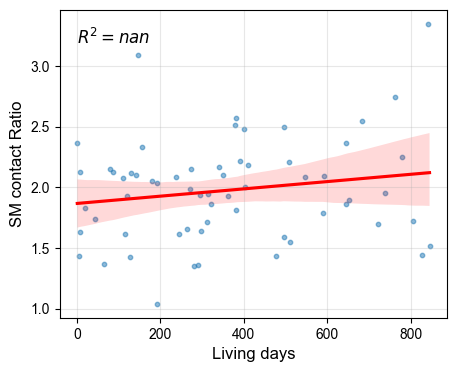

In [239]:
from scipy.stats import linregress
# 回归线
x = overlapmeta['PATH_DIAG_TO_DEATH_DAYS']
y = overlapmeta['ratio']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value**2  # 计算 R^2 值

# 绘制散点图和回归线
plt.figure(figsize=(5, 4))
sns.regplot(x=x, y=y, scatter_kws={'s': 10, 'alpha': 0.5}, line_kws={'color': 'red'})

# 添加 R^2 值到图中
plt.text(
    x.min(), y.max() * 0.95,  # 文本位置
    f'$R^2 = {r_squared:.3f}$',  # 格式化 R^2
    fontsize=12, color='black'
)

# 设置标题和标签
#plt.title('Scatter plot with regression line', fontsize=15)
plt.xlabel('Living days', fontsize=12)
plt.ylabel('SM contact Ratio', fontsize=12)
plt.grid(alpha=0.3)

In [241]:
overlapmeta.to_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/2021.csv',index=False)

### 原始数据

In [218]:
# 原始数据，每个样本中SM出现的次数

orin=pd.crosstab(SNP['Tumor_Sample_Barcode'], SNP['hg19id']).gt(0).astype(int)
#orin=SNP.pivot_table(index='Tumor_Sample_Barcode',columns='hg19id',aggfunc=lambda x: 1, fill_value=0)
metaorin=pd.merge(meta_simple.iloc[:,:6],orin,left_on='PATIENT_ID',right_index=True,how='inner')

In [220]:
metaorin['sum']=metaorin.iloc[:,6:].sum(axis=1)
metaorin.loc[:,['PATH_DIAG_TO_DEATH_DAYS','sum']].corr(method='spearman')

,PATH_DIAG_TO_DEATH_DAYS,sum
PATH_DIAG_TO_DEATH_DAYS,1.000000,0.069639
sum,0.069639,1.000000


In [202]:
SMsum=metaorin.iloc[:,[0,-1]].sort_values(by='sum',ascending=False).head(10)

In [221]:
metaorin.head()

,PATIENT_ID,PATH_DIAG_TO_DEATH_DAYS,PATH_DIAG_TO_LAST_CONTACT_DAYS,CAUSE_OF_DEATH,VITAL_STATUS,LOST_TO_FOLLOW_UP,chr10_100017842_100017842,chr10_100183413_100183413,chr10_100481428_100481428,chr10_100481448_100481448,...,chrX_99854625_99854625,chrY_23710716_23710716,chrY_23710825_23710825,chrY_3447670_3447670,chrY_3447809_3447809,chrY_4925071_4925071,chrY_4925496_4925496,chrY_5605441_5605441,chrY_9304672_9304672,sum
0,C3L-00104,129.0,128.0,NaN,Deceased,No,0,0,0,0,...,0,0,0,0,0,0,0,0,0,78
1,C3L-00365,322.0,280.0,NaN,Deceased,No,0,0,0,0,...,0,0,0,0,0,0,0,0,0,66
2,C3L-00674,478.0,385.0,GBM,Deceased,No,0,0,0,0,...,0,0,0,0,0,0,0,0,0,44
3,C3L-00677,155.0,155.0,GBM,Deceased,No,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1004
4,C3L-01040,NaN,608.0,NaN,Living,Yes,0,0,0,0,...,0,0,0,0,0,1,0,0,0,94


### non-overlapped SM   
从上面得到的数据

In [ ]:
# 每个 sample 的 non overlap SM的的数量
nonoverlap=all_persample-overlap_persample

In [199]:
nonoverlap.head()

Tumor_Sample_Barcode
C3L-00104     34
C3L-00365     35
C3L-00674     27
C3L-00677    379
C3L-01040     43
Name: hg19id, dtype: int64

## loop Coverage

In [ ]:
coverage=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/result/all/loop_coverage.txt',sep='\t',header=None)
hg38=pd.read_csv('/cluster/home/futing/ref_genome/hg38.genome',sep='\t',header=None)
hg38.columns=['chr','length']
coverage.columns=['chr','length','num']
hg38=hg38.loc[~hg38['chr'].str.contains('chrY'),:]

In [ ]:
coverage.shape,hg38.shape

((23, 3), (23, 2))

In [ ]:
coverage=coverage.loc[coverage['chr'].isin(hg38['chr']),:]
hg38=hg38.set_index('chr')
coverage=coverage.set_index('chr').reindex(hg38.index,fill_value=0).reset_index()

In [ ]:
coverage=pd.merge(hg38,coverage,on='chr',how='left')
coverage['ratio']=coverage['length_y']*100/coverage['length_x']

In [ ]:
coverage.sort_values('ratio',ascending=False)

,chr,length_x,length_y,num,ratio
18,chr19,58617616,16320000,337,27.841460
16,chr17,83257441,14390000,319,17.283740
19,chr20,64444167,11000000,257,17.069039
6,chr7,159345973,24310000,577,15.256112
11,chr12,133275309,19260000,451,14.451289
15,chr16,90338345,10910000,265,12.076821
0,chr1,248956422,29690000,735,11.925782
10,chr11,135086622,16090000,395,11.910876
14,chr15,101991189,10330000,246,10.128326
7,chr8,145138636,14180000,347,9.769969


## Loop 

In [104]:
loop=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/result/all/GBMfil_merged.bed',sep='\t')

In [ ]:
loop.head()

,chr,start,end,P455.SF11901,P475.SF12180,P498.SF12251,P503.SF12518,P519.SF12601,P521.SF12631,P524.SF12681v1,...,U343,U87,G523,G567,G583,U251,H4,42MGBA,num,NonNA_Count
0,chr1,775000,855000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,chr1,785000,224045000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,15
2,chr1,825000,224015000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3,chr1,895000,5665000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
4,chr1,905000,975000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,9


In [105]:
loop.columns

Index(['chr', 'start', 'end', 'P455.SF11901', 'P475.SF12180', 'P498.SF12251',
       'P503.SF12518', 'P519.SF12601', 'P521.SF12631', 'P524.SF12681v1',
       'P524.SF12681v4', 'P524.SF12681v9', 'P529.SF12794v1-1',
       'P529.SF12794v6-1', 'P529.SF12794v8-1', 'P530.SF12822v10',
       'P530.SF12822v13', 'P530.SF12822v14', 'P530.SF12822v15',
       'P530.SF12822v18', 'P530.SF12822v19', 'P530.SF12822v2',
       'P530.SF12822v4', 'P530.SF12822v5', 'G1', 'G23', 'G28', 'G61', 'G62',
       'G83', 'G120', 'G148', 'G163', 'G171', 'G181', 'G208', 'G213', 'G275',
       'G275R', 'G318', 'G323', 'G351', 'G390', 'G394', 'G402', 'G402R',
       'G412', 'G412R', 'G450', 'G452C', 'G452P', 'G457', 'A172', 'SW1088',
       'U118', 'U343', 'U87', 'G523', 'G567', 'G583', 'U251', 'H4', '42MGBA',
       'num', 'NonNA_Count'],
      dtype='object')

In [110]:
nloop=loop['NonNA_Count'].value_counts()
nloop.sum()

176605

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


/tmp/ipykernel_10724/2897715124.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nloop.index, y=nloop.values, palette="viridis")
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


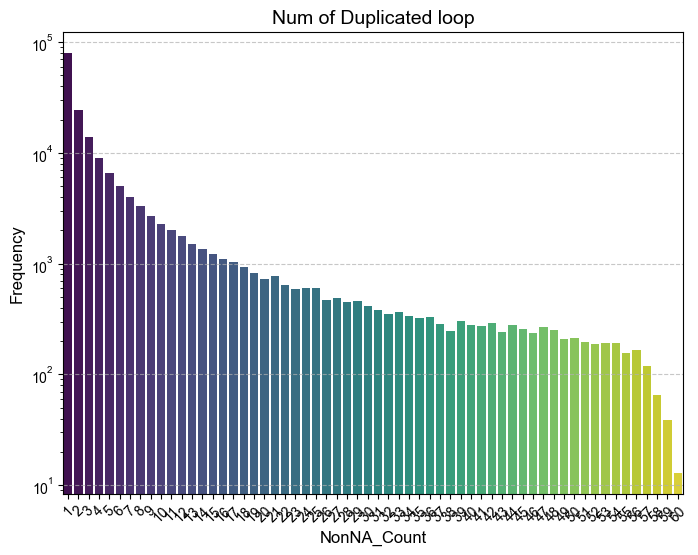

In [ ]:

plt.figure(figsize=(8, 6))
sns.barplot(x=nloop.index, y=nloop.values)
plt.title("Distribution of loops across samples", fontsize=14)
plt.xlabel("Num of samples a loop appears in", fontsize=12)
plt.ylabel("Num of samples", fontsize=12)
plt.yscale('log')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)